In [4]:
# Google Colab에서 한글 폰트 설정
# !fc-cache -fv
# !rm ~/.cache/matplotlib -rf

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [5]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

[온라인 상품 거래 데이터 분석을 통한 고객 이탈 예측]

1. 가상 데이터 생성 중...
생성된 데이터 샘플:
  customer_id  age  gender registration_date  total_purchase  \
0  CUST_00001   39       0        2022-07-09           18538   
1  CUST_00002   33       0        2022-05-16           17128   
2  CUST_00003   41       1        2023-07-09          102558   
3  CUST_00004   50       1        2023-02-08           55844   
4  CUST_00005   32       0        2023-08-25           79649   

   purchase_frequency last_purchase_date  cart_abandonment_rate  \
0                   6         2023-12-05               0.194836   
1                   3         2023-09-26               0.210213   
2                   2         2023-09-13               0.346867   
3                   7         2024-01-01               0.343961   
4                   7         2023-11-22               0.414424   

   avg_session_time  return_count  cs_inquiries  app_usage  \
0          2.657206             1             1          1   
1          9.829512      

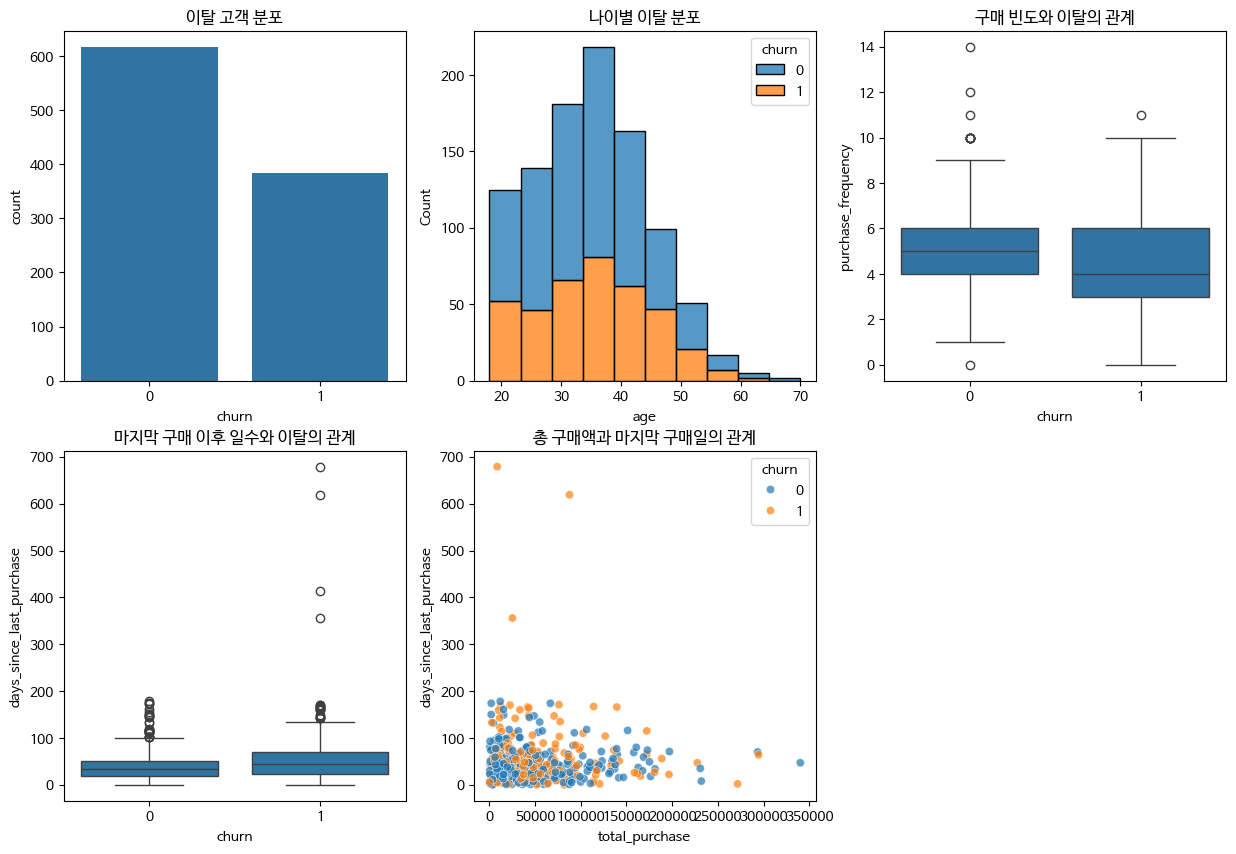

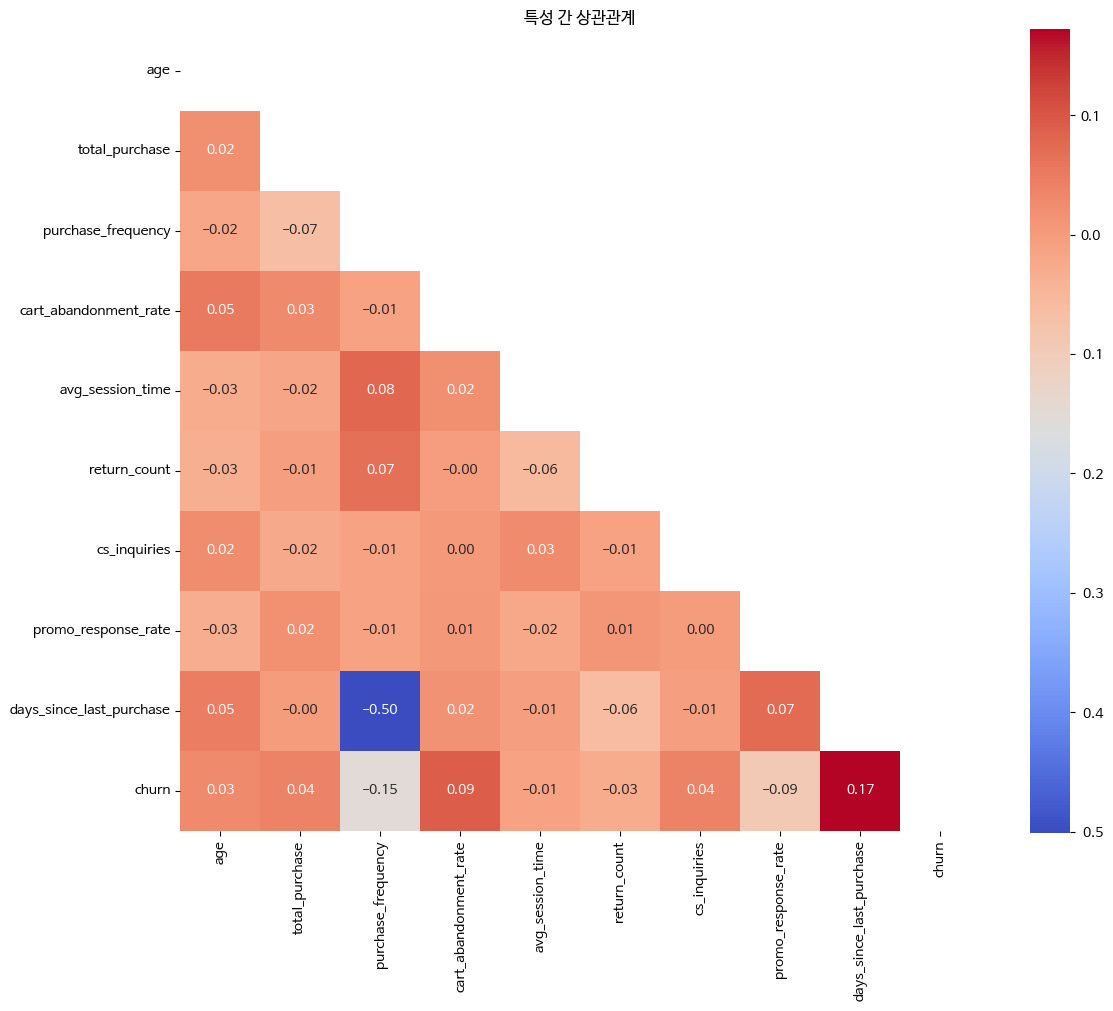


4. 이탈 예측 모델 학습 및 평가 중...

[모델 평가 결과]
              precision    recall  f1-score   support

           0       0.64      0.87      0.74       123
           1       0.52      0.22      0.31        77

    accuracy                           0.62       200
   macro avg       0.58      0.55      0.52       200
weighted avg       0.59      0.62      0.57       200



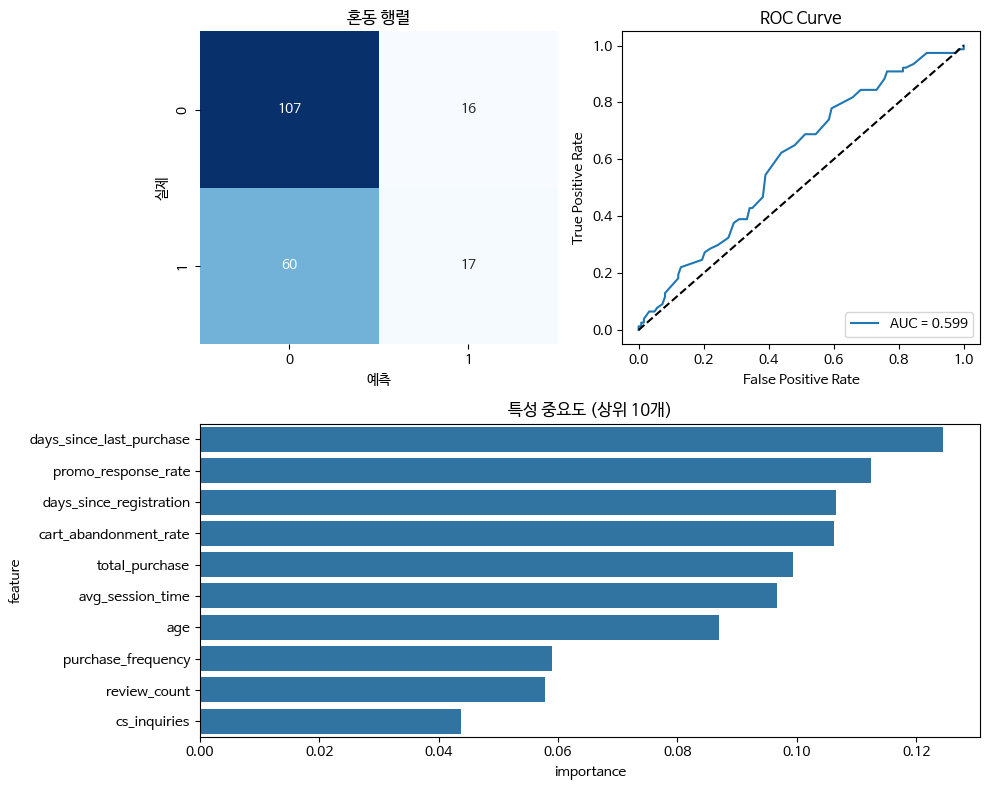


5. 이탈 위험이 높은 고객 식별 중...

이탈 위험이 높은 고객 수: 273 (전체의 27.30%)

[이탈 위험이 가장 높은 고객 10명]
    customer_id  churn_probability  days_since_last_purchase  \
562  CUST_00563               0.94                       5.0   
933  CUST_00934               0.93                     166.0   
234  CUST_00235               0.92                      77.0   
824  CUST_00825               0.91                     170.0   
307  CUST_00308               0.91                     168.0   
284  CUST_00285               0.91                     159.0   
38   CUST_00039               0.91                     105.0   
943  CUST_00944               0.91                     147.0   
187  CUST_00188               0.90                     144.0   
944  CUST_00945               0.90                     167.0   

     purchase_frequency  total_purchase  cart_abandonment_rate  cs_inquiries  
562                 6.0         30771.0               0.271433           0.0  
933                 2.0        139460.0               0

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# 시드 설정
np.random.seed(42)

# 1. 가상 데이터 생성
def generate_ecommerce_data(n_customers=1000):
    """온라인 상품 거래 데이터를 생성합니다."""

    # 고객 ID 생성
    customer_ids = [f'CUST_{i:05d}' for i in range(1, n_customers + 1)]

    # 기본 특성 생성
    age = np.random.normal(35, 10, n_customers)
    age = np.clip(age, 18, 70).astype(int)

    # 성별 (0: 여성, 1: 남성)
    gender = np.random.binomial(1, 0.48, n_customers)

    # 회원 가입일
    start_date = datetime(2022, 1, 1)
    days_range = 365 * 2  # 2년 기간
    reg_days = np.random.randint(0, days_range, n_customers)
    registration_dates = [start_date + timedelta(days=int(days)) for days in reg_days]

    # 총 구매 금액
    base_purchase = np.random.exponential(scale=50000, size=n_customers)
    total_purchase = np.round(base_purchase).astype(int)

    # 구매 빈도 (연간)
    purchase_frequency = np.random.poisson(lam=5, size=n_customers)
    purchase_frequency = np.clip(purchase_frequency, 0, 30)

    # 마지막 구매 일자
    last_purchase_days = np.zeros(n_customers)
    for i in range(n_customers):
        # 구매 빈도가 높을수록 최근에 구매했을 가능성이 높음
        if purchase_frequency[i] > 0:
            max_days = min(180, 365 / purchase_frequency[i])
            last_purchase_days[i] = np.random.randint(0, int(max_days))
        else:
            # 구매 빈도가 0인 경우, 가입 직후 이탈했다고 가정
            last_purchase_days[i] = reg_days[i]

    last_purchase_dates = [(datetime(2024, 1, 1) - timedelta(days=int(days))).strftime('%Y-%m-%d')
                            for days in last_purchase_days]

    # 장바구니 포기율
    cart_abandonment_rate = np.random.beta(2, 5, n_customers)

    # 평균 세션 시간 (분)
    avg_session_time = np.random.gamma(shape=2, scale=5, size=n_customers)

    # 반품 횟수
    return_count = np.random.poisson(lam=0.5, size=n_customers)

    # 고객 서비스 문의 횟수
    cs_inquiries = np.random.poisson(lam=1, size=n_customers)

    # 앱 사용 여부 (0: 사용 안함, 1: 사용함)
    app_usage = np.random.binomial(1, 0.7, n_customers)

    # 프로모션 반응률
    promo_response_rate = np.random.beta(1.5, 3, n_customers)

    # 제품 리뷰 수
    review_count = np.random.poisson(lam=purchase_frequency * 0.6, size=n_customers)

    # VIP 등급 (0-4, 숫자가 클수록 높은 등급)
    vip_tier = np.zeros(n_customers, dtype=int)
    for i in range(n_customers):
        if total_purchase[i] > 200000 and purchase_frequency[i] > 10:
            vip_tier[i] = 4
        elif total_purchase[i] > 100000 and purchase_frequency[i] > 7:
            vip_tier[i] = 3
        elif total_purchase[i] > 50000 and purchase_frequency[i] > 4:
            vip_tier[i] = 2
        elif total_purchase[i] > 20000 and purchase_frequency[i] > 2:
            vip_tier[i] = 1

    # 이탈 여부 결정 (0: 유지, 1: 이탈)
    # 아래 요소들이 이탈에 영향을 미친다고 가정:
    # - 마지막 구매 일자가 오래될수록 이탈 가능성 증가
    # - 구매 빈도가 낮을수록 이탈 가능성 증가
    # - 장바구니 포기율이 높을수록 이탈 가능성 증가
    # - 고객 서비스 문의가 많을수록 이탈 가능성 증가
    # - 앱을 사용하지 않으면 이탈 가능성 증가
    # - 프로모션 반응률이 낮을수록 이탈 가능성 증가

    churn_probability = (
        0.3 * (last_purchase_days / 180) +
        0.2 * (1 - np.minimum(purchase_frequency, 10) / 10) +
        0.15 * cart_abandonment_rate +
        0.1 * np.minimum(cs_inquiries, 5) / 5 +
        0.1 * (1 - app_usage) +
        0.15 * (1 - promo_response_rate)
    )

    # 확률에 약간의 노이즈 추가
    churn_probability = np.clip(churn_probability + np.random.normal(0, 0.1, n_customers), 0, 1)

    # 이탈 여부 결정
    churn = (np.random.random(n_customers) < churn_probability).astype(int)

    # 데이터프레임 생성
    df = pd.DataFrame({
        'customer_id': customer_ids,
        'age': age,
        'gender': gender,
        'registration_date': registration_dates,
        'total_purchase': total_purchase,
        'purchase_frequency': purchase_frequency,
        'last_purchase_date': last_purchase_dates,
        'cart_abandonment_rate': cart_abandonment_rate,
        'avg_session_time': avg_session_time,
        'return_count': return_count,
        'cs_inquiries': cs_inquiries,
        'app_usage': app_usage,
        'promo_response_rate': promo_response_rate,
        'review_count': review_count,
        'vip_tier': vip_tier,
        'churn': churn
    })

    # 일부 값을 NaN으로 설정하여 현실적인 데이터 만들기
    mask = np.random.random(n_customers) < 0.05  # 5%의 데이터를 NaN으로 설정
    df.loc[mask, 'avg_session_time'] = np.nan

    mask = np.random.random(n_customers) < 0.02  # 2%의 데이터를 NaN으로 설정
    df.loc[mask, 'cart_abandonment_rate'] = np.nan

    return df

# 2. 데이터 탐색 및 전처리 함수
def explore_and_preprocess_data(df):
    """데이터를 탐색하고 전처리합니다."""

    # 데이터 정보 출력
    print(f"데이터 크기: {df.shape}")
    print("\n결측치 확인:")
    print(df.isnull().sum())

    # 이탈 비율 확인
    churn_rate = df['churn'].mean()
    print(f"\n이탈 비율: {churn_rate:.2%}")

    # 날짜 형식 변환
    df['registration_date'] = pd.to_datetime(df['registration_date'])
    df['last_purchase_date'] = pd.to_datetime(df['last_purchase_date'])

    # 날짜 기반 특성 생성
    current_date = datetime(2024, 1, 1)
    df['days_since_registration'] = (current_date - df['registration_date']).dt.days
    df['days_since_last_purchase'] = (current_date - df['last_purchase_date']).dt.days

    # 범주형 변수 처리
    df['gender'] = df['gender'].map({0: 'Female', 1: 'Male'})
    df['app_usage'] = df['app_usage'].map({0: 'No', 1: 'Yes'})

    # 수치형 변수 스케일링을 위한 준비
    numeric_columns = ['age', 'total_purchase', 'purchase_frequency', 'cart_abandonment_rate',
                      'avg_session_time', 'return_count', 'cs_inquiries', 'promo_response_rate',
                      'review_count', 'days_since_registration', 'days_since_last_purchase']

    # 결측치 처리
    imputer = SimpleImputer(strategy='median')
    df[numeric_columns] = imputer.fit_transform(df[numeric_columns])

    # 범주형 변수를 더미 변수로 변환
    df_encoded = pd.get_dummies(df, columns=['gender', 'app_usage', 'vip_tier'], drop_first=False)

    return df_encoded

# 3. 데이터 시각화 함수
def visualize_data(df):
    """데이터를 시각화합니다."""

    plt.figure(figsize=(15, 10))

    # 이탈 여부에 따른 분포 시각화
    plt.subplot(2, 3, 1)
    sns.countplot(x='churn', data=df)
    plt.title('이탈 고객 분포')

    # 나이 분포
    plt.subplot(2, 3, 2)
    sns.histplot(data=df, x='age', hue='churn', multiple='stack', bins=10)
    plt.title('나이별 이탈 분포')

    # 구매 빈도와 이탈의 관계
    plt.subplot(2, 3, 3)
    sns.boxplot(x='churn', y='purchase_frequency', data=df)
    plt.title('구매 빈도와 이탈의 관계')

    # 마지막 구매 이후 일수와 이탈의 관계
    plt.subplot(2, 3, 4)
    sns.boxplot(x='churn', y='days_since_last_purchase', data=df)
    plt.title('마지막 구매 이후 일수와 이탈의 관계')

    # 총 구매액과 이탈의 관계
    plt.subplot(2, 3, 5)
    df_sample = df.sample(min(500, len(df)))  # 데이터가 많을 경우 샘플링
    sns.scatterplot(x='total_purchase', y='days_since_last_purchase',
                   hue='churn', data=df_sample, alpha=0.7)
    plt.title('총 구매액과 마지막 구매일의 관계')

    # 상관관계 분석
    plt.figure(figsize=(12, 10))
    corr_columns = ['age', 'total_purchase', 'purchase_frequency',
                    'cart_abandonment_rate', 'avg_session_time',
                    'return_count', 'cs_inquiries', 'promo_response_rate',
                    'days_since_last_purchase', 'churn']

    corr = df[corr_columns].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title('특성 간 상관관계')

    plt.tight_layout()
    plt.show()

# 4. 모델 학습 및 평가 함수
def train_and_evaluate_model(df):
    """이탈 예측 모델을 학습하고 평가합니다."""

    # 특성과 타겟 분리
    features = df.drop(['customer_id', 'registration_date', 'last_purchase_date', 'churn'], axis=1)
    target = df['churn']

    # 학습 및 테스트 데이터 분리
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

    # 특성 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 랜덤 포레스트 모델 학습
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train)

    # 테스트 데이터 예측
    y_pred = rf_model.predict(X_test_scaled)
    y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

    # 모델 평가
    print("\n[모델 평가 결과]")
    print(classification_report(y_test, y_pred))

    # 혼동 행렬 시각화
    plt.figure(figsize=(10, 8))

    plt.subplot(2, 2, 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('예측')
    plt.ylabel('실제')
    plt.title('혼동 행렬')

    # ROC 커브 시각화
    plt.subplot(2, 2, 2)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    # 특성 중요도 시각화
    plt.subplot(2, 1, 2)
    feature_importance = pd.DataFrame({
        'feature': features.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)

    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('특성 중요도 (상위 10개)')

    plt.tight_layout()
    plt.show()

    return rf_model, scaler, features.columns

# 5. 이탈 위험이 높은 고객 식별 함수
def identify_high_risk_customers(df, model, scaler, feature_names, threshold=0.7):
    """이탈 위험이 높은 고객을 식별합니다."""

    # 특성 데이터 준비
    features = df[feature_names]
    features_scaled = scaler.transform(features)

    # 이탈 확률 예측
    churn_proba = model.predict_proba(features_scaled)[:, 1]
    df['churn_probability'] = churn_proba

    # 이탈 위험이 높은 고객 식별
    high_risk_customers = df[df['churn_probability'] >= threshold].sort_values('churn_probability', ascending=False)

    print(f"\n이탈 위험이 높은 고객 수: {len(high_risk_customers)} (전체의 {len(high_risk_customers)/len(df):.2%})")

    # 상위 10명 고객 정보 출력
    print("\n[이탈 위험이 가장 높은 고객 10명]")
    risk_columns = ['customer_id', 'churn_probability', 'days_since_last_purchase',
                    'purchase_frequency', 'total_purchase', 'cart_abandonment_rate', 'cs_inquiries']
    print(high_risk_customers[risk_columns].head(10))

    return high_risk_customers

# 6. 이탈 방지 전략 제안 함수
def suggest_retention_strategies(high_risk_df):
    """고객 특성 기반 이탈 방지 전략을 제안합니다."""

    # 각 고객별 맞춤 전략 수립
    strategies = []

    for _, customer in high_risk_df.iterrows():
        customer_id = customer['customer_id']
        strategy = {
            'customer_id': customer_id,
            'churn_probability': customer['churn_probability'],
            'strategies': []
        }

        # 마지막 구매 이후 오랜 시간이 지난 경우
        if customer['days_since_last_purchase'] > 60:
            strategy['strategies'].append("재방문 유도 프로모션 발송")

        # 장바구니 포기율이 높은 경우
        if customer['cart_abandonment_rate'] > 0.5:
            strategy['strategies'].append("장바구니 제품 할인 쿠폰 발송")

        # CS 문의가 많은 경우
        if customer['cs_inquiries'] > 2:
            strategy['strategies'].append("고객 서비스 개선 및 개인화된 응대")

        # 앱을 사용하지 않는 경우
        if customer['app_usage_No'] == 1:
            strategy['strategies'].append("앱 설치 및 사용 혜택 안내")

        # 프로모션 반응률이 낮은 경우
        if customer['promo_response_rate'] < 0.3:
            strategy['strategies'].append("관심 제품 기반 맞춤형 프로모션 제공")

        # VIP 등급이 높은 경우 (이탈 시 손실이 큰 고객)
        if (customer.get('vip_tier_3', 0) == 1 or customer.get('vip_tier_4', 0) == 1) and customer['total_purchase'] > 100000:
            strategy['strategies'].append("VIP 전용 특별 혜택 및 개인화된 감사 메시지")

        strategies.append(strategy)

    # 전략 요약
    print("\n[고객 이탈 방지 전략 요약]")
    strategy_counts = {}

    for strategy in strategies:
        for s in strategy['strategies']:
            if s in strategy_counts:
                strategy_counts[s] += 1
            else:
                strategy_counts[s] = 1

    for strategy, count in sorted(strategy_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"- {strategy}: {count}명 ({count/len(strategies):.2%})")

    return strategies

# 메인 함수: 전체 분석 실행
def main():
    print("[온라인 상품 거래 데이터 분석을 통한 고객 이탈 예측]")

    # 1. 가상 데이터 생성
    print("\n1. 가상 데이터 생성 중...")
    df = generate_ecommerce_data(n_customers=1000)
    print(f"생성된 데이터 샘플:\n{df.head()}")

    # 2. 데이터 탐색 및 전처리
    print("\n2. 데이터 탐색 및 전처리 중...")
    df_processed = explore_and_preprocess_data(df)

    # 3. 데이터 시각화
    print("\n3. 데이터 시각화 중...")
    visualize_data(df)

    # 4. 모델 학습 및 평가
    print("\n4. 이탈 예측 모델 학습 및 평가 중...")
    model, scaler, feature_names = train_and_evaluate_model(df_processed)

    # 5. 이탈 위험이 높은 고객 식별
    print("\n5. 이탈 위험이 높은 고객 식별 중...")
    high_risk_customers = identify_high_risk_customers(df_processed, model, scaler, feature_names)

    # 6. 이탈 방지 전략 제안
    print("\n6. 고객별 이탈 방지 전략 제안...")
    retention_strategies = suggest_retention_strategies(high_risk_customers)

    print("\n[분석 완료]")
    print("위 결과를 바탕으로 고객 이탈을 예방하기 위한 맞춤형 전략을 수립하고 실행할 수 있습니다.")

# 프로그램 실행
if __name__ == "__main__":
    main()

[온라인 상품 거래 데이터 분석을 통한 고객 이탈 예측]

1. 가상 데이터 생성 중...
생성된 데이터 샘플:
       고객_아이디  나이  성별      가입_날짜   총_구매액  구매_빈도   마지막_구매_날짜  장바구니_포기율  \
0  CUST_00001  39   0 2022-07-09   18538      6  2023-12-05  0.194836   
1  CUST_00002  33   0 2022-05-16   17128      3  2023-09-26  0.210213   
2  CUST_00003  41   1 2023-07-09  102558      2  2023-09-13  0.346867   
3  CUST_00004  50   1 2023-02-08   55844      7  2024-01-01  0.343961   
4  CUST_00005  32   0 2023-08-25   79649      7  2023-11-22  0.414424   

    평균_세션_시간  반품_횟수  고객서비스_문의수  앱_사용_여부  프로모션_반응률  리뷰_수  VIP_등급  이탈_여부  
0   2.657206      1          1        1  0.346942     4       0      0  
1   9.829512      1          1        0  0.371318     2       0      0  
2   3.817164      1          3        1  0.150023     2       0      1  
3   4.658376      0          0        0  0.480150     6       2      0  
4  14.302000      0          1        0  0.557911     6       2      0  

2. 데이터 탐색 및 전처리 중...
데이터 크기: (1000, 16)

결측치 확인:
고객_아이디    

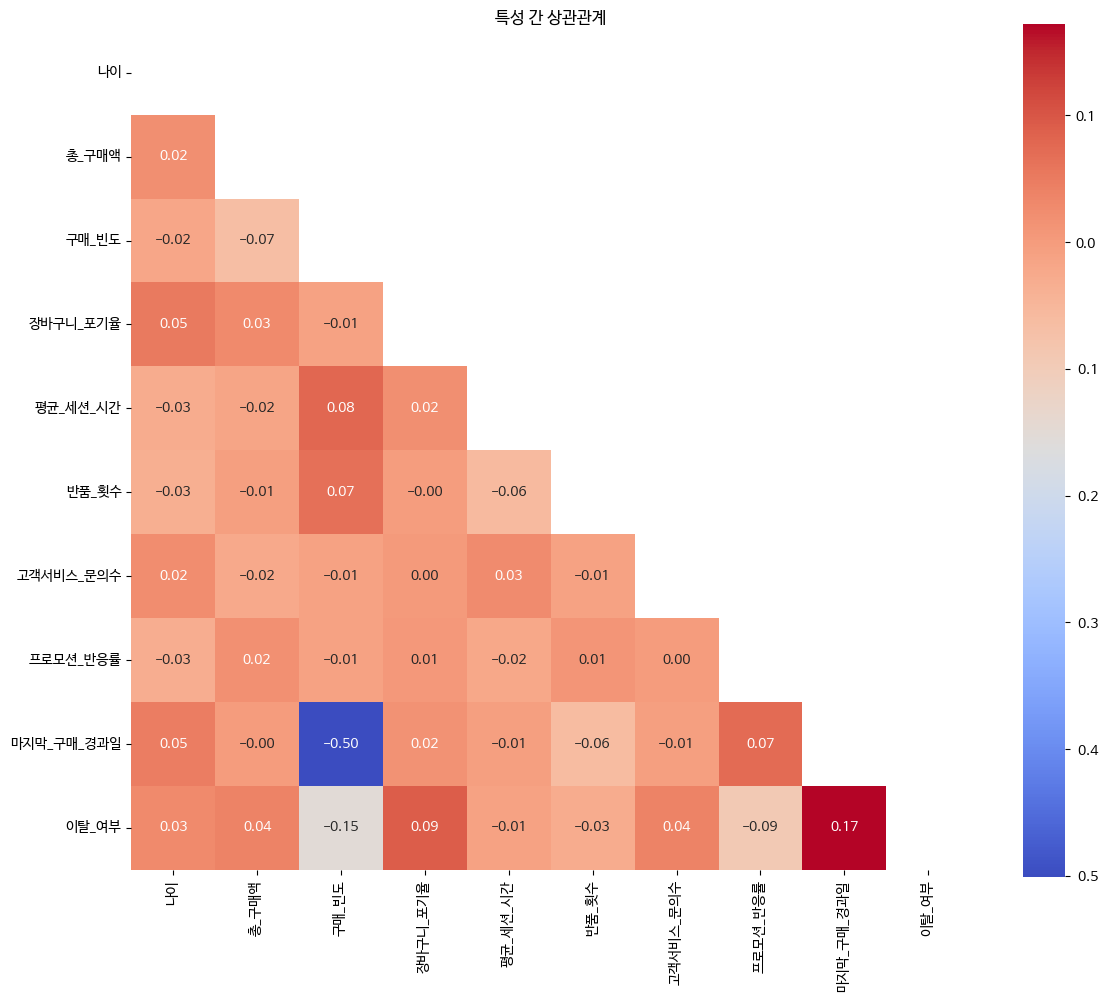


4. 이탈 예측 모델 학습 및 평가 중...

[모델 평가 결과]
              precision    recall  f1-score   support

           0       0.63      0.82      0.71       123
           1       0.45      0.23      0.31        77

    accuracy                           0.59       200
   macro avg       0.54      0.53      0.51       200
weighted avg       0.56      0.59      0.56       200




5. 이탈 위험이 높은 고객 식별 중...

이탈 위험이 높은 고객 수: 274 (전체의 27.40%)

[이탈 위험이 가장 높은 고객 10명]
         고객_아이디  이탈_확률  마지막_구매_경과일  구매_빈도     총_구매액  장바구니_포기율  고객서비스_문의수
933  CUST_00934   0.94       166.0    2.0  139460.0  0.185039        2.0
562  CUST_00563   0.93         5.0    6.0   30771.0  0.271433        0.0
247  CUST_00248   0.93        72.0    3.0   60558.0  0.140001        4.0
187  CUST_00188   0.92       144.0    2.0   36181.0  0.219222        1.0
62   CUST_00063   0.92       129.0    2.0  151230.0  0.171392        1.0
735  CUST_00736   0.92        58.0    6.0   29594.0  0.186968        2.0
38   CUST_00039   0.91       105.0    2.0   16170.0  0.208416        2.0
510  CUST_00511   0.91        62.0    5.0   31275.0  0.658853        2.0
414  CUST_00415   0.90        50.0    4.0    6968.0  0.164959        1.0
988  CUST_00989   0.90        41.0    4.0  133248.0  0.149394        4.0

6. 고객별 이탈 방지 전략 제안...

[고객 이탈 방지 전략 요약]
- 관심 제품 기반 맞춤형 프로모션 제공: 153명 (55.84%)
- 앱 설치 및 사용 혜택 안내: 112명 (40.88%)
- 재

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# 시드 설정
np.random.seed(42)

# 1. 가상 데이터 생성
def 가상_데이터_생성(고객_수=1000):
    """온라인 상품 거래 데이터를 생성합니다."""

    # 고객 ID 생성
    고객_아이디 = [f'CUST_{i:05d}' for i in range(1, 고객_수 + 1)]

    # 기본 특성 생성
    나이 = np.random.normal(35, 10, 고객_수)
    나이 = np.clip(나이, 18, 70).astype(int)

    # 성별 (0: 여성, 1: 남성)
    성별 = np.random.binomial(1, 0.48, 고객_수)

    # 회원 가입일
    시작_날짜 = datetime(2022, 1, 1)
    날짜_범위 = 365 * 2  # 2년 기간
    가입_경과일 = np.random.randint(0, 날짜_범위, 고객_수)
    가입_날짜 = [시작_날짜 + timedelta(days=int(일수)) for 일수 in 가입_경과일]

    # 총 구매 금액
    기본_구매액 = np.random.exponential(scale=50000, size=고객_수)
    총_구매액 = np.round(기본_구매액).astype(int)

    # 구매 빈도 (연간)
    구매_빈도 = np.random.poisson(lam=5, size=고객_수)
    구매_빈도 = np.clip(구매_빈도, 0, 30)

    # 마지막 구매 일자
    마지막_구매_경과일 = np.zeros(고객_수)
    for i in range(고객_수):
        # 구매 빈도가 높을수록 최근에 구매했을 가능성이 높음
        if 구매_빈도[i] > 0:
            최대_일수 = min(180, 365 / 구매_빈도[i])
            마지막_구매_경과일[i] = np.random.randint(0, int(최대_일수))
        else:
            # 구매 빈도가 0인 경우, 가입 직후 이탈했다고 가정
            마지막_구매_경과일[i] = 가입_경과일[i]

    마지막_구매_날짜 = [(datetime(2024, 1, 1) - timedelta(days=int(일수))).strftime('%Y-%m-%d')
                        for 일수 in 마지막_구매_경과일]

    # 장바구니 포기율
    장바구니_포기율 = np.random.beta(2, 5, 고객_수)

    # 평균 세션 시간 (분)
    평균_세션_시간 = np.random.gamma(shape=2, scale=5, size=고객_수)

    # 반품 횟수
    반품_횟수 = np.random.poisson(lam=0.5, size=고객_수)

    # 고객 서비스 문의 횟수
    고객서비스_문의수 = np.random.poisson(lam=1, size=고객_수)

    # 앱 사용 여부 (0: 사용 안함, 1: 사용함)
    앱_사용_여부 = np.random.binomial(1, 0.7, 고객_수)

    # 프로모션 반응률
    프로모션_반응률 = np.random.beta(1.5, 3, 고객_수)

    # 제품 리뷰 수
    리뷰_수 = np.random.poisson(lam=구매_빈도 * 0.6, size=고객_수)

    # VIP 등급 (0-4, 숫자가 클수록 높은 등급)
    VIP_등급 = np.zeros(고객_수, dtype=int)
    for i in range(고객_수):
        if 총_구매액[i] > 200000 and 구매_빈도[i] > 10:
            VIP_등급[i] = 4
        elif 총_구매액[i] > 100000 and 구매_빈도[i] > 7:
            VIP_등급[i] = 3
        elif 총_구매액[i] > 50000 and 구매_빈도[i] > 4:
            VIP_등급[i] = 2
        elif 총_구매액[i] > 20000 and 구매_빈도[i] > 2:
            VIP_등급[i] = 1

    # 이탈 여부 결정 (0: 유지, 1: 이탈)
    # 아래 요소들이 이탈에 영향을 미친다고 가정:
    # - 마지막 구매 일자가 오래될수록 이탈 가능성 증가
    # - 구매 빈도가 낮을수록 이탈 가능성 증가
    # - 장바구니 포기율이 높을수록 이탈 가능성 증가
    # - 고객 서비스 문의가 많을수록 이탈 가능성 증가
    # - 앱을 사용하지 않으면 이탈 가능성 증가
    # - 프로모션 반응률이 낮을수록 이탈 가능성 증가

    이탈_가능성 = (
        0.3 * (마지막_구매_경과일 / 180) +
        0.2 * (1 - np.minimum(구매_빈도, 10) / 10) +
        0.15 * 장바구니_포기율 +
        0.1 * np.minimum(고객서비스_문의수, 5) / 5 +
        0.1 * (1 - 앱_사용_여부) +
        0.15 * (1 - 프로모션_반응률)
    )

    # 확률에 약간의 노이즈 추가
    이탈_가능성 = np.clip(이탈_가능성 + np.random.normal(0, 0.1, 고객_수), 0, 1)

    # 이탈 여부 결정
    이탈_여부 = (np.random.random(고객_수) < 이탈_가능성).astype(int)

    # 데이터프레임 생성
    데이터 = pd.DataFrame({
        '고객_아이디': 고객_아이디,
        '나이': 나이,
        '성별': 성별,
        '가입_날짜': 가입_날짜,
        '총_구매액': 총_구매액,
        '구매_빈도': 구매_빈도,
        '마지막_구매_날짜': 마지막_구매_날짜,
        '장바구니_포기율': 장바구니_포기율,
        '평균_세션_시간': 평균_세션_시간,
        '반품_횟수': 반품_횟수,
        '고객서비스_문의수': 고객서비스_문의수,
        '앱_사용_여부': 앱_사용_여부,
        '프로모션_반응률': 프로모션_반응률,
        '리뷰_수': 리뷰_수,
        'VIP_등급': VIP_등급,
        '이탈_여부': 이탈_여부
    })

    # 일부 값을 NaN으로 설정하여 현실적인 데이터 만들기
    마스크 = np.random.random(고객_수) < 0.05  # 5%의 데이터를 NaN으로 설정
    데이터.loc[마스크, '평균_세션_시간'] = np.nan

    마스크 = np.random.random(고객_수) < 0.02  # 2%의 데이터를 NaN으로 설정
    데이터.loc[마스크, '장바구니_포기율'] = np.nan

    return 데이터

# 2. 데이터 탐색 및 전처리 함수
def 데이터_탐색_및_전처리(데이터):
    """데이터를 탐색하고 전처리합니다."""

    # 데이터 정보 출력
    print(f"데이터 크기: {데이터.shape}")
    print("\n결측치 확인:")
    print(데이터.isnull().sum())

    # 이탈 비율 확인
    이탈_비율 = 데이터['이탈_여부'].mean()
    print(f"\n이탈 비율: {이탈_비율:.2%}")

    # 날짜 형식 변환
    데이터['가입_날짜'] = pd.to_datetime(데이터['가입_날짜'])
    데이터['마지막_구매_날짜'] = pd.to_datetime(데이터['마지막_구매_날짜'])

    # 날짜 기반 특성 생성
    현재_날짜 = datetime(2024, 1, 1)
    데이터['가입_경과일'] = (현재_날짜 - 데이터['가입_날짜']).dt.days
    데이터['마지막_구매_경과일'] = (현재_날짜 - 데이터['마지막_구매_날짜']).dt.days

    # 범주형 변수 처리
    데이터['성별'] = 데이터['성별'].map({0: '여성', 1: '남성'})
    데이터['앱_사용_여부'] = 데이터['앱_사용_여부'].map({0: '미사용', 1: '사용'})

    # 수치형 변수 스케일링을 위한 준비
    수치형_열 = ['나이', '총_구매액', '구매_빈도', '장바구니_포기율',
                 '평균_세션_시간', '반품_횟수', '고객서비스_문의수', '프로모션_반응률',
                 '리뷰_수', '가입_경과일', '마지막_구매_경과일']

    # 결측치 처리
    임퓨터 = SimpleImputer(strategy='median')
    데이터[수치형_열] = 임퓨터.fit_transform(데이터[수치형_열])

    # 범주형 변수를 더미 변수로 변환
    인코딩된_데이터 = pd.get_dummies(데이터, columns=['성별', '앱_사용_여부', 'VIP_등급'], drop_first=False)

    return 인코딩된_데이터

# 3. 데이터 시각화 함수
def 데이터_시각화(데이터):
    """데이터를 시각화합니다."""

    plt.figure(figsize=(15, 10))

    # 이탈 여부에 따른 분포 시각화
    plt.subplot(2, 3, 1)
    sns.countplot(x='이탈_여부', data=데이터)
    plt.title('이탈 고객 분포')

    # 나이 분포
    plt.subplot(2, 3, 2)
    sns.histplot(data=데이터, x='나이', hue='이탈_여부', multiple='stack', bins=10)
    plt.title('나이별 이탈 분포')

    # 구매 빈도와 이탈의 관계
    plt.subplot(2, 3, 3)
    sns.boxplot(x='이탈_여부', y='구매_빈도', data=데이터)
    plt.title('구매 빈도와 이탈의 관계')

    # 마지막 구매 이후 일수와 이탈의 관계
    plt.subplot(2, 3, 4)
    sns.boxplot(x='이탈_여부', y='마지막_구매_경과일', data=데이터)
    plt.title('마지막 구매 이후 일수와 이탈의 관계')

    # 총 구매액과 이탈의 관계
    plt.subplot(2, 3, 5)
    데이터_샘플 = 데이터.sample(min(500, len(데이터)))  # 데이터가 많을 경우 샘플링
    sns.scatterplot(x='총_구매액', y='마지막_구매_경과일',
                   hue='이탈_여부', data=데이터_샘플, alpha=0.7)
    plt.title('총 구매액과 마지막 구매일의 관계')

    # 상관관계 분석
    plt.figure(figsize=(12, 10))
    상관관계_분석_열 = ['나이', '총_구매액', '구매_빈도',
                     '장바구니_포기율', '평균_세션_시간',
                     '반품_횟수', '고객서비스_문의수', '프로모션_반응률',
                     '마지막_구매_경과일', '이탈_여부']

    상관계수 = 데이터[상관관계_분석_열].corr()
    마스크 = np.triu(np.ones_like(상관계수, dtype=bool))
    sns.heatmap(상관계수, mask=마스크, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title('특성 간 상관관계')

    plt.tight_layout()
    plt.show()

# 4. 모델 학습 및 평가 함수
def 모델_학습_및_평가(데이터):
    """이탈 예측 모델을 학습하고 평가합니다."""

    # 특성과 타겟 분리
    특성 = 데이터.drop(['고객_아이디', '가입_날짜', '마지막_구매_날짜', '이탈_여부'], axis=1)
    타겟 = 데이터['이탈_여부']

    # 학습 및 테스트 데이터 분리
    X_학습, X_테스트, y_학습, y_테스트 = train_test_split(특성, 타겟, test_size=0.2, random_state=42, stratify=타겟)

    # 특성 스케일링
    스케일러 = StandardScaler()
    X_학습_스케일링 = 스케일러.fit_transform(X_학습)
    X_테스트_스케일링 = 스케일러.transform(X_테스트)

    # 랜덤 포레스트 모델 학습
    랜덤포레스트_모델 = RandomForestClassifier(n_estimators=100, random_state=42)
    랜덤포레스트_모델.fit(X_학습_스케일링, y_학습)

    # 테스트 데이터 예측
    y_예측 = 랜덤포레스트_모델.predict(X_테스트_스케일링)
    y_예측_확률 = 랜덤포레스트_모델.predict_proba(X_테스트_스케일링)[:, 1]

    # 모델 평가
    print("\n[모델 평가 결과]")
    print(classification_report(y_테스트, y_예측))

    # 혼동 행렬 시각화
    plt.figure(figsize=(10, 8))

    plt.subplot(2, 2, 1)
    혼동_행렬 = confusion_matrix(y_테스트, y_예측)
    sns.heatmap(혼동_행렬, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('예측')
    plt.ylabel('실제')
    plt.title('혼동 행렬')

    # ROC 커브 시각화
    plt.subplot(2, 2, 2)
    fpr, tpr, _ = roc_curve(y_테스트, y_예측_확률)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    # 특성 중요도 시각화
    plt.subplot(2, 1, 2)
    특성_중요도 = pd.DataFrame({
        '특성': 특성.columns,
        '중요도': 랜덤포레스트_모델.feature_importances_
    }).sort_values('중요도', ascending=False).head(10)

    sns.barplot(x='중요도', y='특성', data=특성_중요도)
    plt.title('특성 중요도 (상위 10개)')

    plt.tight_layout()
    plt.show()

    return 랜덤포레스트_모델, 스케일러, 특성.columns

# 5. 이탈 위험이 높은 고객 식별 함수
def 고위험_고객_식별(데이터, 모델, 스케일러, 특성_이름, 임계값=0.7):
    """이탈 위험이 높은 고객을 식별합니다."""

    # 특성 데이터 준비
    특성 = 데이터[특성_이름]
    특성_스케일링 = 스케일러.transform(특성)

    # 이탈 확률 예측
    이탈_확률 = 모델.predict_proba(특성_스케일링)[:, 1]
    데이터['이탈_확률'] = 이탈_확률

    # 이탈 위험이 높은 고객 식별
    고위험_고객 = 데이터[데이터['이탈_확률'] >= 임계값].sort_values('이탈_확률', ascending=False)

    print(f"\n이탈 위험이 높은 고객 수: {len(고위험_고객)} (전체의 {len(고위험_고객)/len(데이터):.2%})")

    # 상위 10명 고객 정보 출력
    print("\n[이탈 위험이 가장 높은 고객 10명]")
    위험_열 = ['고객_아이디', '이탈_확률', '마지막_구매_경과일',
             '구매_빈도', '총_구매액', '장바구니_포기율', '고객서비스_문의수']
    print(고위험_고객[위험_열].head(10))

    return 고위험_고객

# 6. 이탈 방지 전략 제안 함수
def 이탈방지_전략_제안(고위험_고객_데이터):
    """고객 특성 기반 이탈 방지 전략을 제안합니다."""

    # 각 고객별 맞춤 전략 수립
    전략_목록 = []

    for _, 고객 in 고위험_고객_데이터.iterrows():
        고객_아이디 = 고객['고객_아이디']
        전략 = {
            '고객_아이디': 고객_아이디,
            '이탈_확률': 고객['이탈_확률'],
            '제안_전략': []
        }

        # 마지막 구매 이후 오랜 시간이 지난 경우
        if 고객['마지막_구매_경과일'] > 60:
            전략['제안_전략'].append("재방문 유도 프로모션 발송")

        # 장바구니 포기율이 높은 경우
        if 고객['장바구니_포기율'] > 0.5:
            전략['제안_전략'].append("장바구니 제품 할인 쿠폰 발송")

        # CS 문의가 많은 경우
        if 고객['고객서비스_문의수'] > 2:
            전략['제안_전략'].append("고객 서비스 개선 및 개인화된 응대")

        # 앱을 사용하지 않는 경우
        if 고객.get('앱_사용_여부_미사용', 0) == 1:
            전략['제안_전략'].append("앱 설치 및 사용 혜택 안내")

        # 프로모션 반응률이 낮은 경우
        if 고객['프로모션_반응률'] < 0.3:
            전략['제안_전략'].append("관심 제품 기반 맞춤형 프로모션 제공")

        # VIP 등급이 높은 경우 (이탈 시 손실이 큰 고객)
        if (고객.get('VIP_등급_3', 0) == 1 or 고객.get('VIP_등급_4', 0) == 1) and 고객['총_구매액'] > 100000:
            전략['제안_전략'].append("VIP 전용 특별 혜택 및 개인화된 감사 메시지")

        전략_목록.append(전략)

    # 전략 요약
    print("\n[고객 이탈 방지 전략 요약]")
    전략_카운트 = {}

    for 전략 in 전략_목록:
        for 세부전략 in 전략['제안_전략']:
            if 세부전략 in 전략_카운트:
                전략_카운트[세부전략] += 1
            else:
                전략_카운트[세부전략] = 1

    for 세부전략, 카운트 in sorted(전략_카운트.items(), key=lambda x: x[1], reverse=True):
        print(f"- {세부전략}: {카운트}명 ({카운트/len(전략_목록):.2%})")

    return 전략_목록

# 메인 함수: 전체 분석 실행
def 메인():
    print("[온라인 상품 거래 데이터 분석을 통한 고객 이탈 예측]")

    # 1. 가상 데이터 생성
    print("\n1. 가상 데이터 생성 중...")
    데이터 = 가상_데이터_생성(고객_수=1000)
    print(f"생성된 데이터 샘플:\n{데이터.head()}")

    # 2. 데이터 탐색 및 전처리
    print("\n2. 데이터 탐색 및 전처리 중...")
    전처리된_데이터 = 데이터_탐색_및_전처리(데이터)

    # 3. 데이터 시각화
    print("\n3. 데이터 시각화 중...")
    데이터_시각화(데이터)

    # 4. 모델 학습 및 평가
    print("\n4. 이탈 예측 모델 학습 및 평가 중...")
    모델, 스케일러, 특성_이름 = 모델_학습_및_평가(전처리된_데이터)

    # 5. 이탈 위험이 높은 고객 식별
    print("\n5. 이탈 위험이 높은 고객 식별 중...")
    고위험_고객 = 고위험_고객_식별(전처리된_데이터, 모델, 스케일러, 특성_이름)

    # 6. 이탈 방지 전략 제안
    print("\n6. 고객별 이탈 방지 전략 제안...")
    이탈방지_전략 = 이탈방지_전략_제안(고위험_고객)

    print("\n[분석 완료]")
    print("위 결과를 바탕으로 고객 이탈을 예방하기 위한 맞춤형 전략을 수립하고 실행할 수 있습니다.")

# 프로그램 실행
if __name__ == "__main__":
    메인()